## Super resolution train

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn
from VGGFeatureLoss import VGG16FeatureLoss

In [3]:
path = Path('test_data')
path_hr = path/'cellsHR'
path_lr = path/'cellsLR'

In [4]:
bs,size=32,96
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
data = get_data(bs,size)

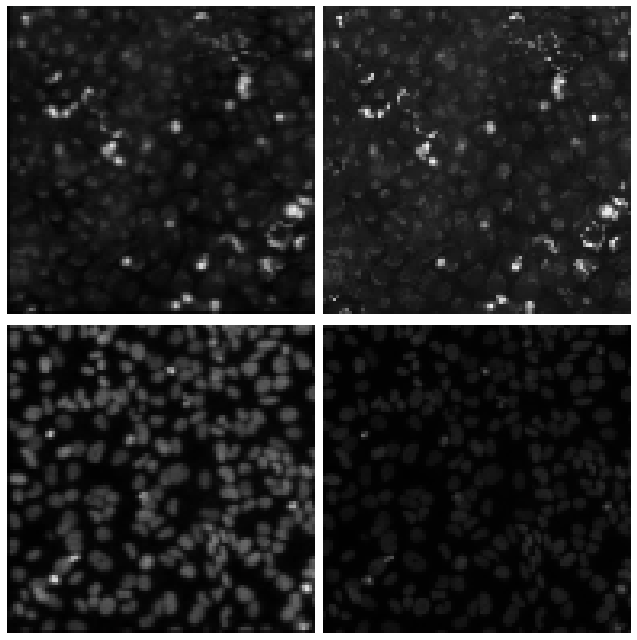

In [7]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [8]:
feat_loss = VGG16FeatureLoss([5,15,2])

## Train

In [9]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, metrics=[mean_squared_error],
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


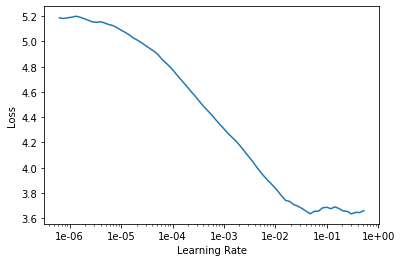

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
lr = 1e-3

In [12]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=5, cmap='gray')

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.949580,1.420032,0.082935,0.208770,0.149009,0.159064,0.034597,0.363014,0.480987,0.024591,00:46
1,1.339530,1.133870,0.064927,0.183448,0.122734,0.130083,0.028509,0.265338,0.382821,0.020937,00:45
2,1.204692,1.055542,0.057147,0.169776,0.115926,0.121951,0.026427,0.244371,0.357682,0.019407,00:45
3,1.120055,1.065908,0.055982,0.173249,0.114142,0.120719,0.026945,0.251364,0.359484,0.020006,00:45
4,1.124443,0.996776,0.046553,0.151650,0.113199,0.118830,0.025878,0.223297,0.344572,0.019350,00:45
5,1.123246,0.979692,0.041366,0.135949,0.113102,0.119100,0.025701,0.223065,0.343605,0.019171,00:45
6,1.082994,0.952758,0.043502,0.142288,0.109176,0.113939,0.024591,0.214942,0.329745,0.018078,00:45
7,1.082514,0.943640,0.036255,0.123394,0.111109,0.118252,0.024985,0.213397,0.334061,0.018441,00:44
8,1.028004,0.931201,0.036333,0.133262,0.108893,0.113074,0.024433,0.208876,0.324483,0.018180,00:45
9,0.971749,0.850566,0.029769,0.111498,0.105729,0.109257,0.023074,0.181290,0.302682,0.017036,00:45


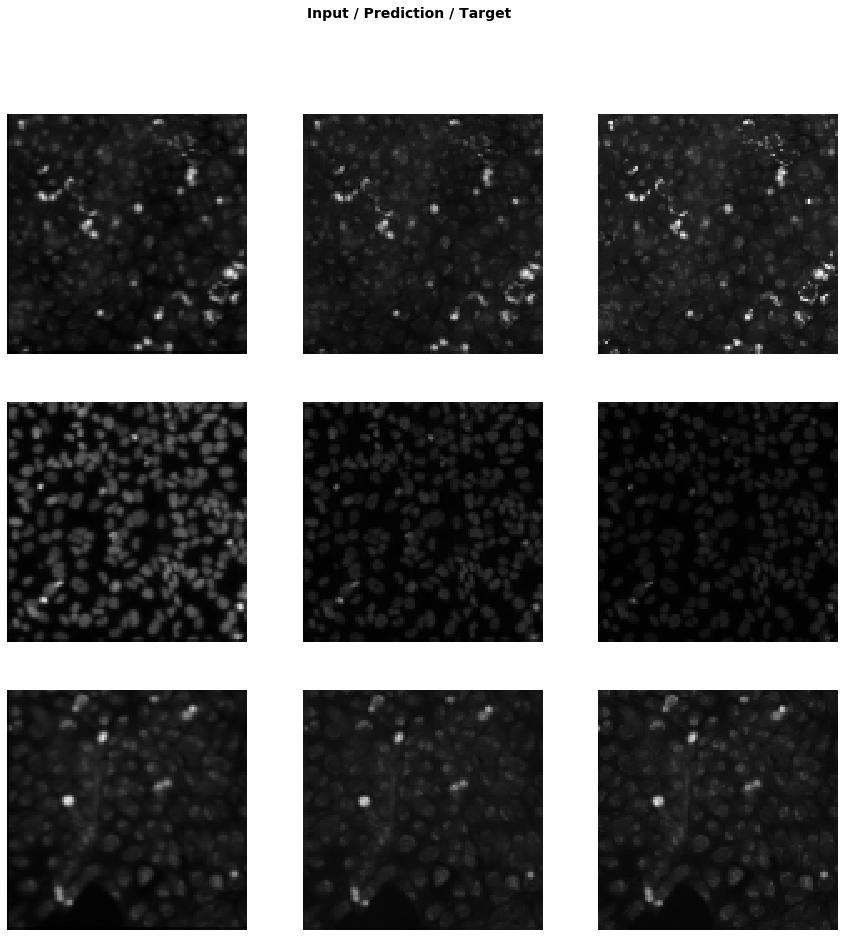

In [13]:
do_fit('1a', slice(lr*10))

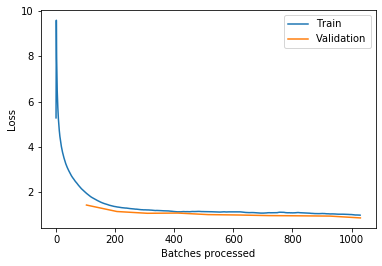

In [14]:
learn.recorder.plot_losses()

In [15]:
learn.unfreeze()

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.937652,0.849055,0.029325,0.110210,0.105716,0.109282,0.023106,0.181217,0.302445,0.017079,00:47
1,0.939866,0.847062,0.029603,0.110406,0.105500,0.109044,0.022976,0.180662,0.301519,0.016954,00:47
2,0.934216,0.839606,0.028642,0.107934,0.104979,0.108572,0.022877,0.178817,0.299542,0.016885,00:47
3,0.930944,0.833590,0.028024,0.107163,0.104392,0.107970,0.022729,0.178151,0.296309,0.016876,00:48
4,0.933170,0.832179,0.026928,0.103339,0.104007,0.107892,0.022868,0.179743,0.297409,0.016920,00:48
5,0.917135,0.801951,0.023175,0.095879,0.102507,0.105505,0.022021,0.171473,0.288385,0.016181,00:48
6,0.916170,0.817239,0.023826,0.097448,0.103178,0.106661,0.022536,0.176193,0.294511,0.016712,00:47
7,0.902325,0.786022,0.021124,0.092276,0.100989,0.103752,0.021694,0.167725,0.283609,0.015975,00:47
8,0.900285,0.806683,0.024485,0.101371,0.100753,0.103768,0.021801,0.175084,0.287871,0.016034,00:48
9,0.885243,0.773993,0.019536,0.087796,0.099886,0.102874,0.021499,0.165414,0.280677,0.015847,00:48


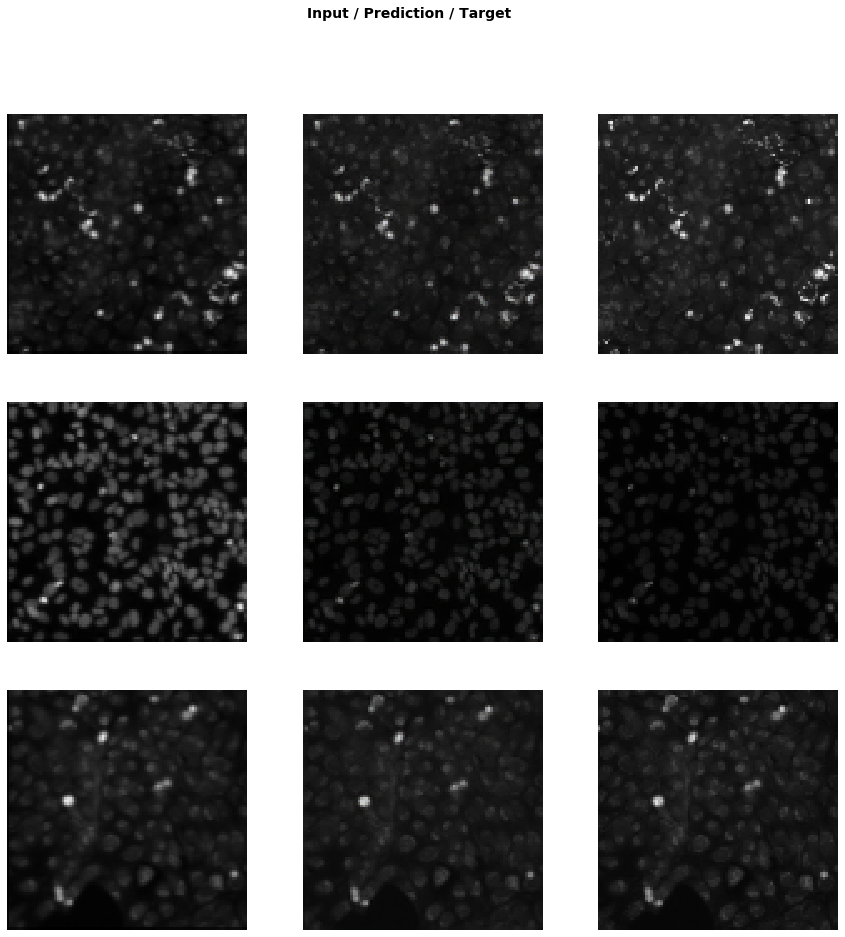

In [16]:
do_fit('1b', slice(1e-5,lr))

In [17]:
data = get_data(8,size*2)

In [19]:
learn.data = data
learn.freeze()
gc.collect()

2929

In [20]:
learn.load('1b');

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.990850,0.797778,0.023937,0.095085,0.156199,0.130583,0.029582,0.186433,0.182368,0.017528,03:10
1,0.974027,0.788681,0.024040,0.096007,0.156659,0.130219,0.029407,0.179397,0.179507,0.017485,03:02
2,0.964809,0.787817,0.025234,0.097927,0.157738,0.130808,0.029502,0.175507,0.178846,0.017489,03:04
3,0.944465,0.782360,0.025565,0.098623,0.158951,0.131017,0.029508,0.170552,0.176355,0.017355,03:02
4,0.922475,0.773911,0.023259,0.093900,0.157845,0.129870,0.028881,0.171132,0.175322,0.016961,03:02
5,0.922301,0.790561,0.026465,0.101674,0.160766,0.132081,0.029603,0.171866,0.176972,0.017599,03:02
6,0.914493,0.781010,0.025909,0.103855,0.158282,0.130088,0.028649,0.169667,0.173555,0.016914,03:04
7,0.909418,0.806649,0.026990,0.100245,0.161927,0.131558,0.028872,0.186193,0.180281,0.017573,03:03
8,0.878889,0.765464,0.026699,0.099415,0.160621,0.130235,0.029126,0.158133,0.170884,0.017050,03:03
9,0.867058,0.739546,0.023668,0.092850,0.158876,0.128877,0.028380,0.148324,0.165757,0.016482,03:11


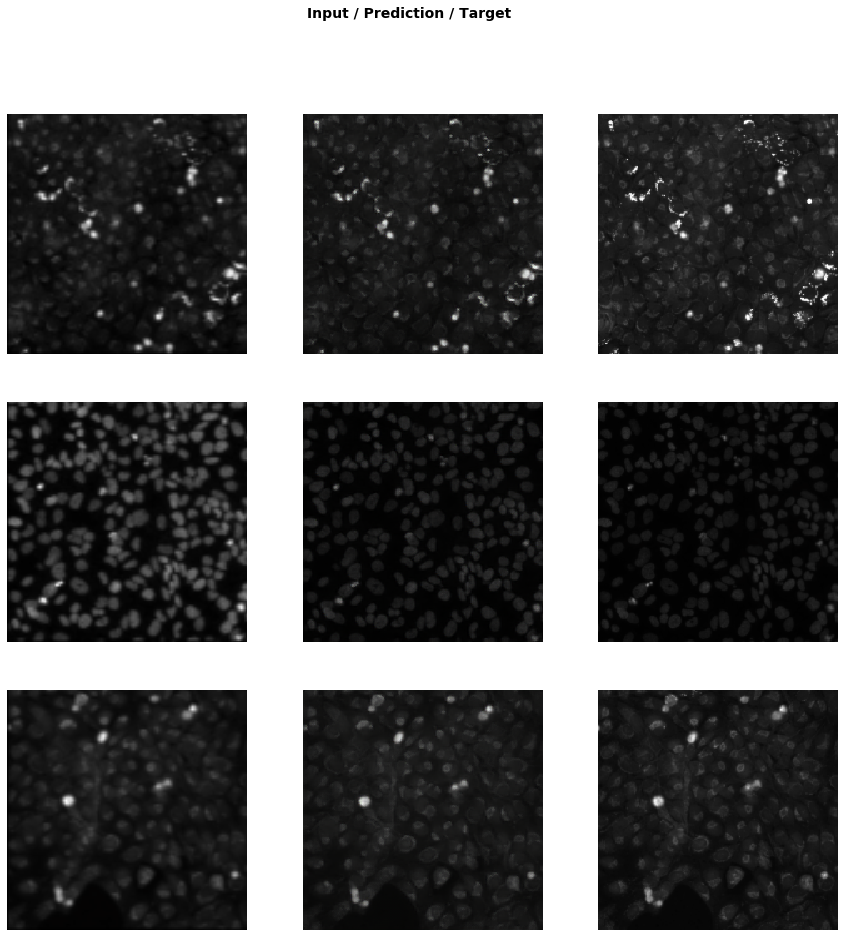

In [21]:
do_fit('2a')

In [22]:
learn.load('2a');

In [23]:
learn.unfreeze()

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.870697,0.741410,0.024188,0.094642,0.159133,0.129078,0.028478,0.147936,0.165537,0.016607,03:16
1,0.872636,0.752058,0.023610,0.097058,0.157124,0.128881,0.028236,0.156160,0.167930,0.016669,03:15
2,0.881327,0.758207,0.022577,0.092410,0.157762,0.129524,0.028679,0.161049,0.171760,0.017024,03:15
3,0.873547,0.746265,0.023089,0.093054,0.157391,0.128580,0.028458,0.153636,0.168475,0.016670,03:15
4,0.855475,0.743729,0.023663,0.094511,0.157795,0.128782,0.028449,0.151618,0.165915,0.016658,03:29
5,0.842617,0.740437,0.024025,0.096264,0.157936,0.128554,0.028216,0.149039,0.164146,0.016281,03:15
6,0.845477,0.728867,0.022734,0.091942,0.156370,0.127301,0.027948,0.145704,0.163437,0.016166,03:23
7,0.830189,0.718369,0.021727,0.090404,0.155731,0.127066,0.027888,0.139663,0.161501,0.016116,03:15
8,0.824784,0.711551,0.020757,0.088319,0.155733,0.127116,0.027833,0.136446,0.160132,0.015973,03:19
9,0.820537,0.712115,0.020998,0.088549,0.155944,0.127184,0.027802,0.136511,0.160148,0.015975,03:44


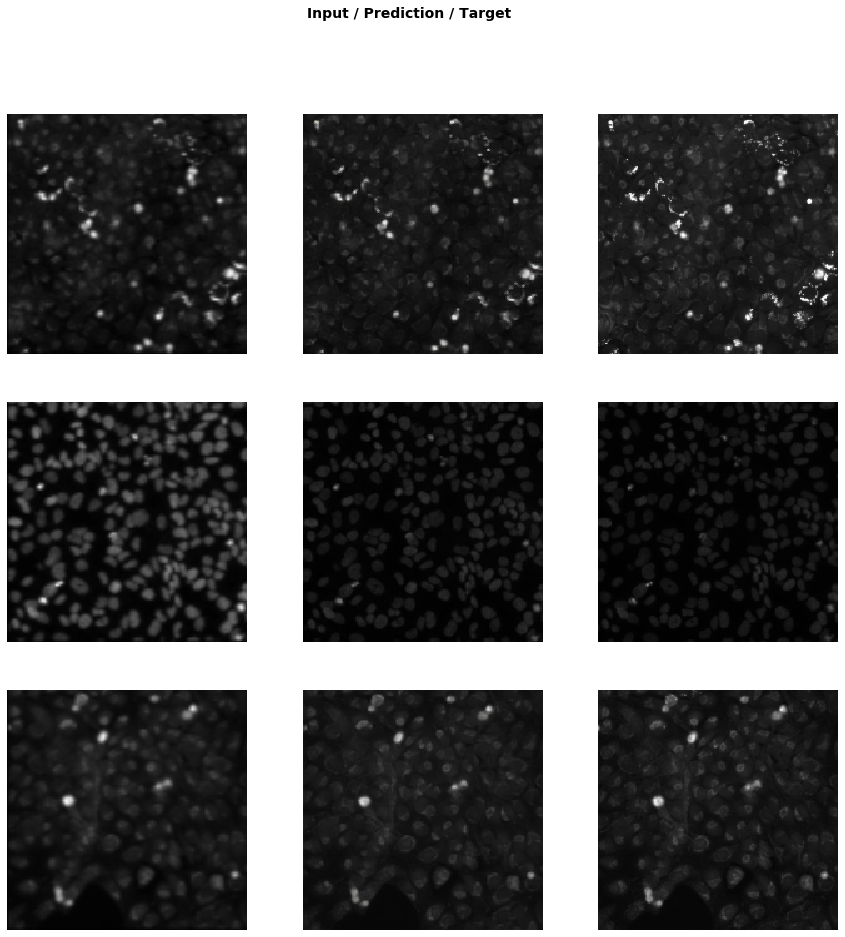

In [24]:
do_fit('2b', slice(1e-5,1e-3), pct_start=0.3)

## Test

In [26]:
learn = None
gc.collect();

In [27]:
size=(300,300)

In [28]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [29]:
data = (ImageImageList.from_folder(path/'cellsLR').split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path/'cellsHR'/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=5).normalize(imagenet_stats, do_y=True))
data.c = 3

In [30]:
learn.load('2b');

In [31]:
learn.data = data

In [104]:
fn_lr = data.valid_ds.x.items[42]; fn_lr
fn_hr = data.valid_ds.y.items[42]; fn_hr

PosixPath('test_data/cellsHR/I18_s1_w5.png')

In [112]:
img_lr = open_image(fn_lr)
img_lr.shape

torch.Size([3, 103, 103])

In [113]:
img_hr = open_image(fn_hr)
img_hr.shape

torch.Size([3, 512, 512])

In [114]:
p,img_pr,b = learn.predict(img_lr)
img_pr.shape

torch.Size([3, 300, 300])

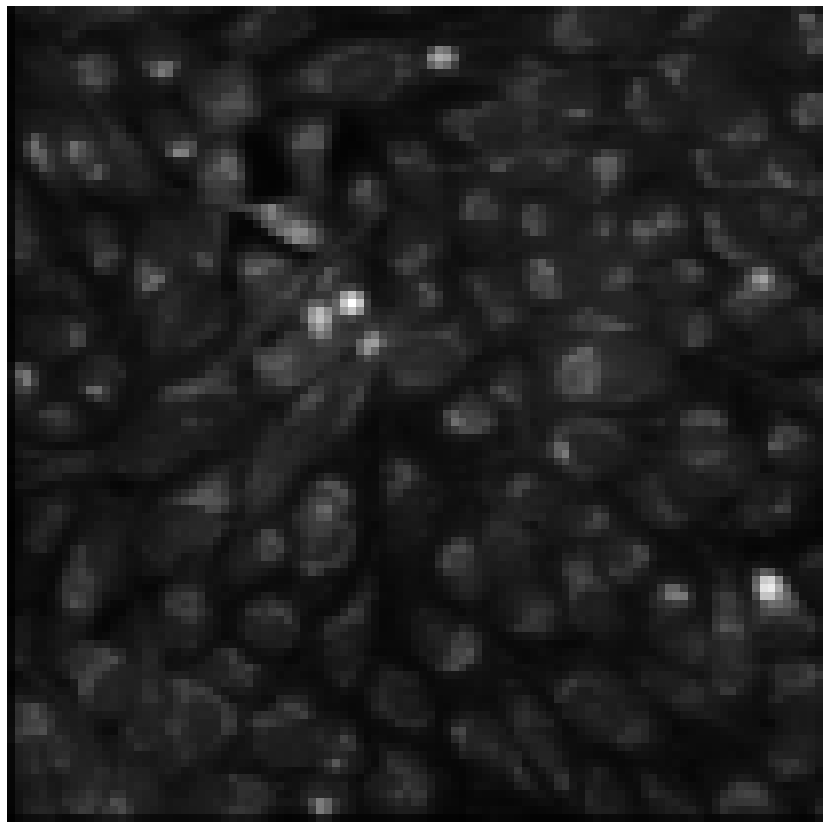

In [108]:
show_image(img_lr, figsize=(15,15), interpolation='nearest');

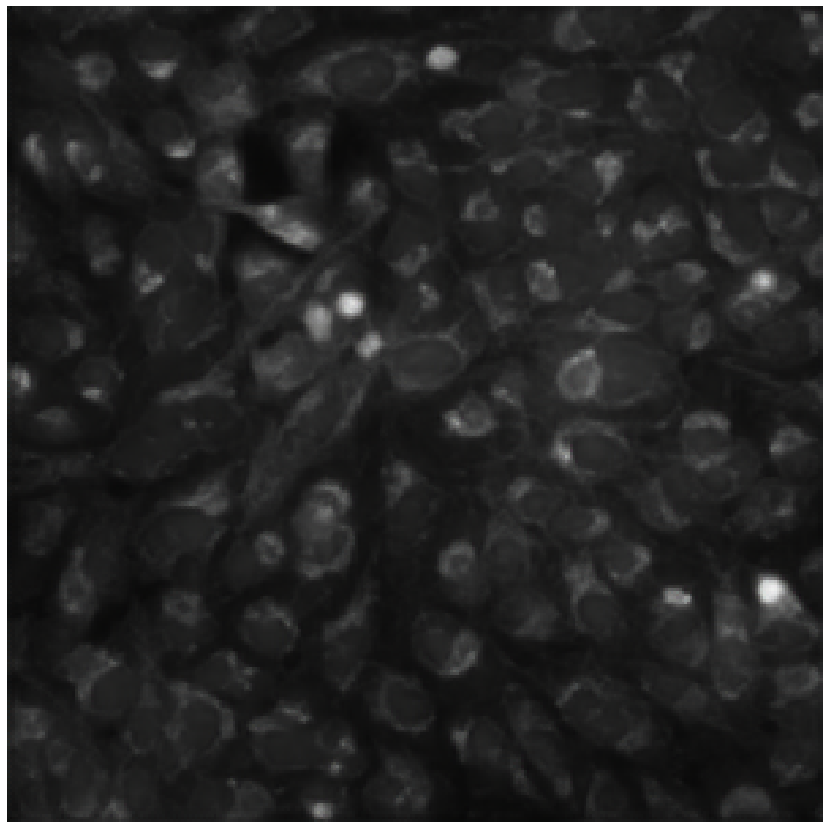

In [109]:
Image(img_pr).show(figsize=(15,15))

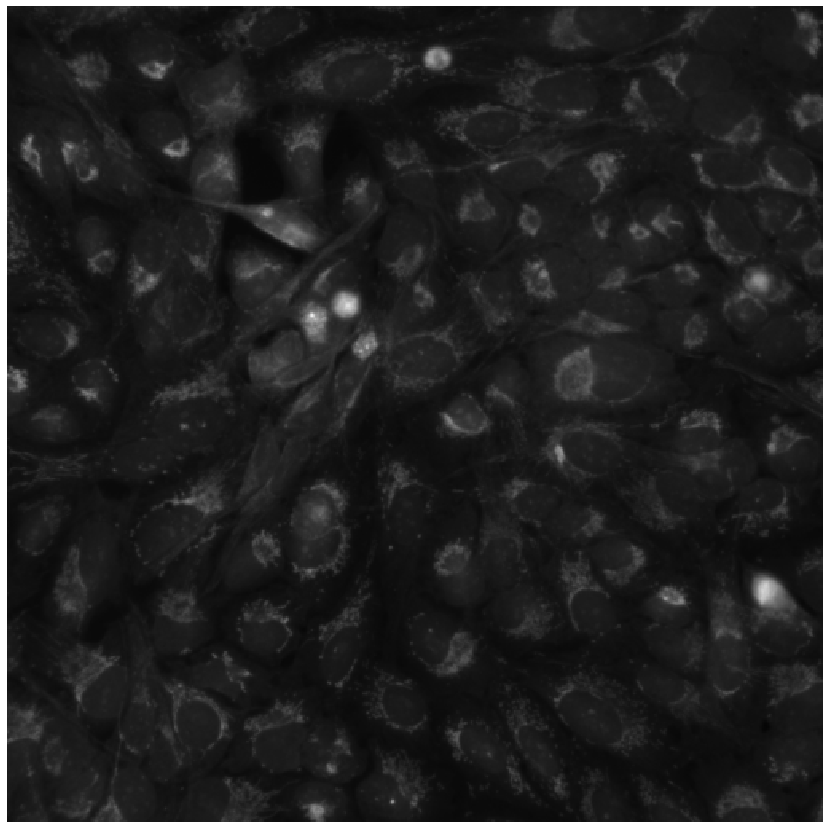

In [110]:
show_image(img_hr, figsize=(15,15), interpolation='nearest');

In [101]:
savepath = Path('./results/cells')

PosixPath('results/cells/H21_s1_w2.png')

In [102]:
def prediction_to_image(arr):
    arr = np.squeeze((img_pr[0]+img_pr[1]+img_pr[2])/3)
    arr = arr/arr.max()*255
    im = PIL.Image.fromarray(np.uint8(arr))
    return im

In [103]:
img_lr.save(savepath/re.sub('\.','_LR.', fn_lr.name))
img_hr.save(savepath/re.sub('\.','_HR.', fn_lr.name))
prediction_to_image(img_pr).save(savepath/re.sub('\.','_PR.', fn_lr.name))